#Structured Task

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

In [ ]:
! git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

In [ ]:
from learn_decoder import *

data = read_matrix("imaging_data.csv", sep=",")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

In [ ]:
vectors = np.array([ft.get_word_vector(concepts[i]) for i in range(len(concepts))])
vectors.shape

(180, 300)

In [ ]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def compute_accuracy(M_decoder, test, vectors, concepts, test_concepts, accuracy_dict, avg_score_lst):
  sum_rank = 0
  # every row in v_pred is a single prediction
  v_pred = (test @ M_decoder)
  cos_dict = {}
  for i in range(test.shape[0]):
    for j, concept in enumerate(concepts):
      cos_dict[concept] = cosine_similarity(vectors[j], v_pred[i])
    rank = len(dict((k,v) for k,v in cos_dict.items() if v > cos_dict[test_concepts[i]])) + 1
    accuracy_dict[test_concepts[i]] = rank
    sum_rank += rank
  avg_score_lst.append(sum_rank/10)


In [ ]:

# Defines
folds = 18
accuracy_dict = {}
avg_score_lst = []

#Run Cross validation
for fold in range(folds):
  test = data[fold*10:(fold+1)*10,:]
  rows_to_remove = list(range(fold*10,(fold+1)*10))
  train = np.delete(data, rows_to_remove, axis=0)
  vectors_train = np.delete(vectors, rows_to_remove, axis=0)
  M_decoder = learn_decoder(train, vectors_train)
  compute_accuracy(M_decoder, test, vectors, concepts , concepts[fold*10:(fold+1)*10], accuracy_dict, avg_score_lst)

In [ ]:
sum = 0
for k,v in accuracy_dict.items():
  sum += v
avg_rank = sum / len(accuracy_dict.items())
print(f'Avereage rank for all items in Fast Text is {round(avg_rank,3)} ')

Avereage rank for all items in Fast Text is 53.206 


In [ ]:
max(avg_score_lst)
min(avg_score_lst)
sum2 = 0
for v in avg_score_lst:
  sum2 += v
avg_fold = sum2/len(avg_score_lst)
avg_fold

53.20555555555555

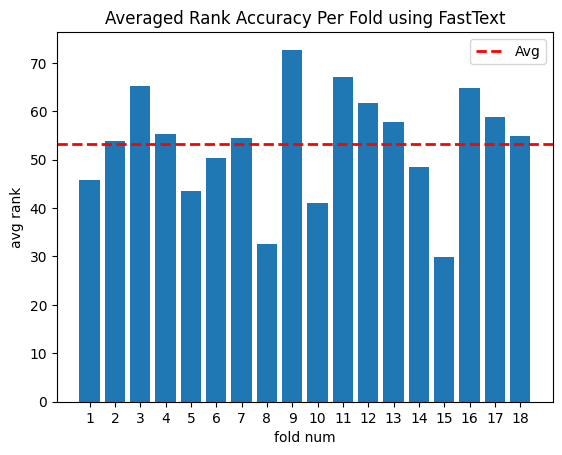

In [ ]:
import matplotlib.pyplot as plt

plt.bar([i+1 for i in range(folds)], avg_score_lst, width=0.8)
plt.title("Averaged Rank Accuracy Per Fold using FastText")
plt.xlabel("fold num")
plt.ylabel("avg rank")
plt.xticks(range(1, folds + 1))
plt.axhline(y=avg_rank, color='red', linestyle='--', linewidth=2, label="Avg")
plt.legend()
plt.show()

**Decoder performance evaluation on experiments 2&3 datasets**

In [ ]:
from learn_decoder import *
exp1_vecs = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [ ]:
from google.colab import drive
import os
import numpy as np
import pickle
import string
import sklearn

drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive/MyDrive/
%cd Structured Task (sentence decoding)

Mounted at /content/gdrive/
/content/gdrive/MyDrive
/content/gdrive/.shortcut-targets-by-id/1gFIrqTvvi6wsowcN3U2iZiVDvEC3fuxq/Structured Task (sentence decoding)


In [ ]:
def read_matrix(filename, sep=","):
    lines = []
    with open(filename) as infile:
        for line in infile:
            lines.append(list(map(float, line.strip().split(sep))))
    return np.array(lines)

def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

def learn_decoder(data, vectors):
     """ Given data (a CxV matrix of V voxel activations per C concepts)
     and vectors (a CxD matrix of D semantic dimensions per C concepts)
     find a matrix M such that the dot product of M and a V-dimensional
     data vector gives a D-dimensional decoded semantic vector.

     The matrix M is learned using ridge regression:
     https://en.wikipedia.org/wiki/Tikhonov_regularization
     """
     ridge = sklearn.linear_model.RidgeCV(
         alphas=[1, 10, .01, 100, .001, 1000, .0001, 10000, .00001, 100000, .000001, 1000000],
         fit_intercept=False
     )
     ridge.fit(data, vectors)
     return ridge.coef_.T

In [ ]:
from numpy import genfromtxt

with open('EXP2.pkl', 'rb') as f:
	exp2 = pickle.load(f)
with open('EXP3.pkl', 'rb') as f:
	exp3 = pickle.load(f)

exp1 = genfromtxt('neuralData_for_EXP1.csv', delimiter=',')
exp1 = exp1[1:,1:]
exp3_vecs = read_matrix("vectors_243sentences.GV42B300.average.txt", sep=" ")
exp2_vecs = read_matrix("vectors_384sentences.GV42B300.average.txt", sep=" ")

In [ ]:
with open('stimuli_243sentences.txt') as file:
    sentences3 = [line.rstrip() for line in file]
for i,sent in enumerate(sentences3):
  sentences3[i] = sent.translate(str.maketrans('', '', string.punctuation))
with open('stimuli_384sentences.txt') as file:
    sentences2 = [line.rstrip() for line in file]
for i,sent in enumerate(sentences2):
  sentences2[i] = sent.translate(str.maketrans('', '', string.punctuation))

In [ ]:
def compute_accuracy(M_decoder, test, real_vecs, sentences, accuracy_dict):
  sum_rank = 0
  # every row in v_pred is a single prediction
  v_pred = (test @ M_decoder)
  cos_dict = {}
  for i in range(test.shape[0]):
    for j, sent in enumerate(sentences):
      cos_dict[sent] = cosine_similarity(real_vecs[j], v_pred[i])
    rank = len(dict((k,v) for k,v in cos_dict.items() if v > cos_dict[sentences[i]])) + 1
    accuracy_dict[sentences[i]] = rank
    sum_rank += rank
  return (sum_rank/test.shape[0])

#Train Decoder
M_decoder = learn_decoder(exp1, exp1_vecs)
#Test section
data2 = exp2['Fmridata']
accuracy_dict2 = {}
data3 = exp3['Fmridata']
accuracy_dict3 = {}
acc2 = compute_accuracy(M_decoder, data2, exp2_vecs, sentences2 , accuracy_dict2)
acc3 = compute_accuracy(M_decoder, data3, exp3_vecs, sentences3 , accuracy_dict3)
print(f'Accuracy on experiment 2 data is: {acc2} , total sentences:{len(sentences2)}')
print(f'Accuracy on experiment 3 data is: {acc3} , total sentences:{len(sentences3)}')

Accuracy on experiment 2 data is: 156.92708333333334 , total sentences:384
Accuracy on experiment 3 data is: 100.7448559670782 , total sentences:243


**Analyze by topics**

In [ ]:
from statistics import mean

def compute_topic_acc(data_dict,sentences,acc_dict):
  topics = [data_dict['keyPassageCategory'][0][i][0] for i in range(len(data_dict['keyPassageCategory'][0]))]
  topic_acc_dict = dict.fromkeys(topics,0)
  for key in topic_acc_dict.keys():
    topic_acc_dict[key] = []
  for index,sentence in enumerate(sentences):
    current_passage_id = data_dict['labelsPassageForEachSentence'][index][0]
    current_topic_id = data_dict['labelsPassageCategory'][current_passage_id-1][0]
    current_topic = data_dict['keyPassageCategory'][0][current_topic_id-1][0]
    topic_acc_dict[current_topic].append(acc_dict[sentence])
  for key in topic_acc_dict.keys():
    topic_acc_dict[key] = sum(topic_acc_dict[key])/len(topic_acc_dict[key])
  return topic_acc_dict

In [ ]:
topic_dict_2 = compute_topic_acc(exp2,sentences2,accuracy_dict2)
topic_dict_3 = compute_topic_acc(exp3,sentences3,accuracy_dict3)

In [ ]:
print('Dataset 2')
dict(sorted(topic_dict_2.items(), key=lambda x: x[1]))

Dataset 2


{'body_part': 70.4375,
 'human': 92.75,
 'drink_non_alcoholic': 98.9375,
 'dwelling': 113.6875,
 'appliance': 113.75,
 'furniture': 131.875,
 'kitchen_utensil': 141.25,
 'disaster': 149.3125,
 'fish': 152.375,
 'tool': 153.0625,
 'bird': 156.3125,
 'place': 157.5,
 'building_part': 158.625,
 'clothing': 160.3125,
 'weapon': 163.8125,
 'crime': 164.875,
 'fruit': 176.3125,
 'landscape': 176.5,
 'insect': 179.875,
 'music': 185.0,
 'vehicles_transport': 186.6875,
 'animal': 196.25,
 'vegetable': 237.625,
 'profession': 249.125}

In [ ]:
print('Dataset 3')
dict(sorted(topic_dict_3.items(), key=lambda x: x[1]))

Dataset 3


{'dreams': 52.8,
 'stress': 58.2,
 'castle': 59.1,
 'opera': 63.63636363636363,
 'bone_fracture': 68.0909090909091,
 'law_school': 68.2,
 'gambling': 71.6,
 'taste': 78.66666666666667,
 'painter': 80.9,
 'polar_bear': 81.7,
 'computer_graphics': 89.5,
 'hurricane': 99.8,
 'tuxedo': 101.4,
 'blindness': 104.9,
 'rock_climbing': 108.18181818181819,
 'astronaut': 110.7,
 'infection': 118.2,
 'ice_cream': 119.6,
 'skiing': 129.5,
 'pharmacist': 136.6,
 'pyramid': 147.2,
 'lawn_mower': 148.1,
 'owl': 148.6,
 'beekeeping': 169.8181818181818}

#Semi-Structured Tasks

We chose using the second experiment dataset.

In [ ]:
#Train Decoder with original sentences repsentation
Origin_decoder = learn_decoder(data2 , exp2_vecs)



In [ ]:
!pip install -U sentence-transformers

In [ ]:
#Train Decoder with sentences represented with contextual word embedding model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
embeddings = model.encode(sentences2)
bert_decoder = learn_decoder(data2, embeddings)

 Now that we have both decoders we can start comparing the results.

a) In this section we will check the average accuracy score over different dataset,
specificallly the third experiment dataset.

In [ ]:
origin_acc_dict = {}
origin_acc = compute_accuracy(Origin_decoder, data3 , exp3_vecs, sentences3, origin_acc_dict)

bert_acc_dict = {}
embeddings3 = model.encode(sentences3)
bert_acc = compute_accuracy(bert_decoder, data3 , embeddings3, sentences3, bert_acc_dict)

In [ ]:
print(f'Usinig the decoder trained on original sentences representaion we get average accuracy of: {origin_acc}')
print(f'Usinig the decoder trained on sentences representd with Bert model we get average accuracy of: {bert_acc}')
print('Therefore by measures of average acc on a whole different data set Bert is better.')

Usinig the decoder trained on original sentences representaion we get average accuracy of: 94.39917695473251
Usinig the decoder trained on sentences representd with Bert model we get average accuracy of: 81.24279835390946
Therefore by measures of average acc on a whole different data set Bert is better.


b) In this section we will check the average accuracy score using Cross Validation method, to check performance over the same dataset.

In [ ]:
def compute_acc_cv(M_decoder, test, vectors, sentences, test_sent):
  sum_rank = 0
  # every row in v_pred is a single prediction
  v_pred = (test @ M_decoder)
  cos_dict = {}
  for i in range(test.shape[0]):
    for j, sent in enumerate(sentences):
      cos_dict[sent] = cosine_similarity(vectors[j], v_pred[i])
    rank = len(dict((k,v) for k,v in cos_dict.items() if v > cos_dict[test_sent[i]])) + 1
    sum_rank += rank
  return (sum_rank/test.shape[0])


folds = 16
avg_score_lst_origin = []
avg_score_lst_bert = []
for fold in range(folds):
  #origin
  test = data2[fold*24:(fold+1)*24,:]
  rows_to_remove = list(range(fold*24,(fold+1)*24))
  train = np.delete(data2, rows_to_remove, axis=0)
  vectors_train = np.delete(exp2_vecs, rows_to_remove, axis=0)
  cv_decoder_origin = learn_decoder(train, vectors_train)
  avg_score_lst_origin.append(compute_acc_cv(cv_decoder_origin, test, exp2_vecs, sentences2 , sentences2[fold*24:(fold+1)*24]))
  #bert
  vectors_train = np.delete(embeddings, rows_to_remove, axis=0)
  cv_decoder_bert = learn_decoder(train, vectors_train)
  avg_score_lst_bert.append(compute_acc_cv(cv_decoder_bert, test, embeddings, sentences2 , sentences2[fold*24:(fold+1)*24]))

In [ ]:
mean_avg_origin = sum(avg_score_lst_origin)/folds
mean_avg_bert = sum(avg_score_lst_bert)/folds
print(f'Average accuracy using original sentences with CV method: {mean_avg_origin}')
print(f'Average accuracy using bert representation sentences with CV method: {mean_avg_bert}')
print('Thus we can see that Bert outperforms the original representation, both on new data and same data.')

Average accuracy using original sentences with CV method: 137.32552083333334
Average accuracy using bert representation sentences with CV method: 118.5078125
Thus we can see that Bert outperforms the original representation, both on new data and same data.


**Building a brain-encoder**

In [ ]:
def compute_rsquare_lst(data,P, X, R_squared):
  for voxel in range(data.shape[1]):
    y = data[:,voxel]
    beta_hat = np.matmul(P, y)
    y_hat = np.matmul(X, beta_hat)
    Y_bar = np.mean(y)
    k = X.shape[1] - 1
    SSR = 0
    SSres = 0
    for i in range(len(y_hat)):
      SSR += (y_hat[i] - Y_bar) ** 2
      SSres += (y[i] - y_hat[i]) ** 2
    SST = SSR + SSres
    R_squared.append(SSR / SST)

#Origin
X = np.c_[np.ones(exp2_vecs.shape[0]), exp2_vecs]
C = np.matmul(X.T, X)
C_inverse = np.linalg.inv(C)
P = np.matmul(C_inverse, X.T)
origin_Rscores = []
compute_rsquare_lst(data2,P, X, origin_Rscores)

#Bert
X = np.c_[np.ones(embeddings.shape[0]), embeddings]
C = np.matmul(X.T, X)
C_inverse = np.linalg.inv(C)
P = np.matmul(C_inverse, X.T)
bert_Rscores = []
compute_rsquare_lst(data2,P, X, bert_Rscores)


<ipython-input-19-b8e3bf33ab16>:14: RuntimeWarning: invalid value encountered in double_scalars
  R_squared.append(SSR / SST)


In [ ]:
significant_thresholds = [0.5,0.7]
cleanedOrigin = [x for x in origin_Rscores if str(x) != 'nan']
cleanedBert = [x for x in bert_Rscores if str(x) != 'nan']
print("General info:")
print(f'Average R squared score using original vectors is: {sum(cleanedOrigin)/len(cleanedOrigin)}')
print(f'Average R squared score using Bert vectors is: {sum(cleanedBert)/len(cleanedBert)}')
print()
print("Significance:")
for thresh in significant_thresholds:
  print(f'Current threshold is: {thresh}')
  counter = 0
  sum_signif_scores = 0
  for score in cleanedOrigin:
    if score >= thresh:
      sum_signif_scores += score
      counter +=1
  if counter>0:
   print(f'Number of significant voxels using original vectors and threshhold of {thresh}: {counter}, with average score: {sum_signif_scores/counter}')
  else:
    print(f'None of the voxels was significant under the threshhold of {thresh}')

  counter = 0
  sum_signif_scores = 0
  for score in cleanedBert:
    if score >= thresh:
      sum_signif_scores += score
      counter +=1
  if counter>0:
    print(f'Number of significant voxels using Bert vectors and threshhold of {thresh}: {counter}, with average score: {sum_signif_scores/counter}')
  else:
    print(f'None of the voxels was significant under the threshhold of {thresh}')
  print()


General info:
Average R squared score using original vectors is: 0.8028327846608895
Average R squared score using Bert vectors is: 0.5008731892617546

Significance:
Current threshold is: 0.5
Number of significant voxels using original vectors and threshhold of 0.5: 185734, with average score: 0.8028327846608895
Number of significant voxels using Bert vectors and threshhold of 0.5: 128950, with average score: 0.5016061666913184

Current threshold is: 0.7
Number of significant voxels using original vectors and threshhold of 0.7: 185678, with average score: 0.8028663713256623
None of the voxels was significant under the threshhold of 0.7



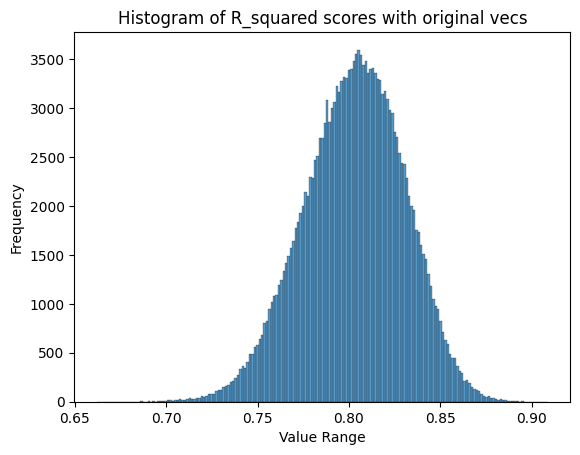

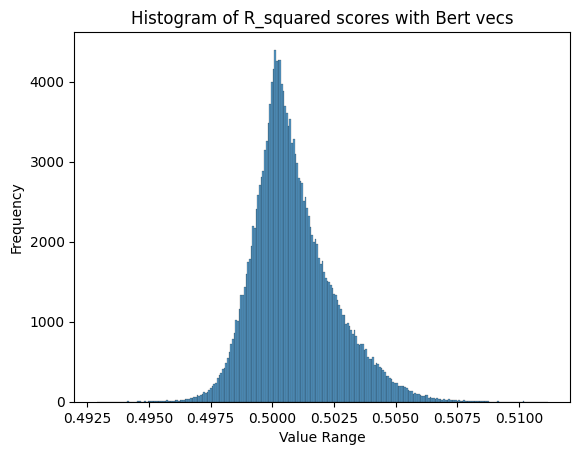

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the histograms
sns.histplot(data=origin_Rscores)
plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.title('Histogram of R_squared scores with original vecs')
plt.show()
print()

sns.histplot(data=bert_Rscores)
plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.title('Histogram of R_squared scores with Bert vecs')
plt.show()

#Open-ended Task

**Is there a connection between a sentence's length and the success of predicting its concept?
We approached the question from two angles:
1)Length as number of words**

**2)Length as number of characters**

In [ ]:
# dict of sentences and their length
len_dict2 = {string: len(string.replace(" ", "")) for string in sentences2}
len_dict3 = {string: len(string.replace(" ", "")) for string in sentences3}

# dict of sentences and number of words
num_words_dict2 = {string: len(string.split()) for string in sentences2}
num_words_dict3 = {string: len(string.split()) for string in sentences3}



**Exploring the length as number of characters using Linear Regression**

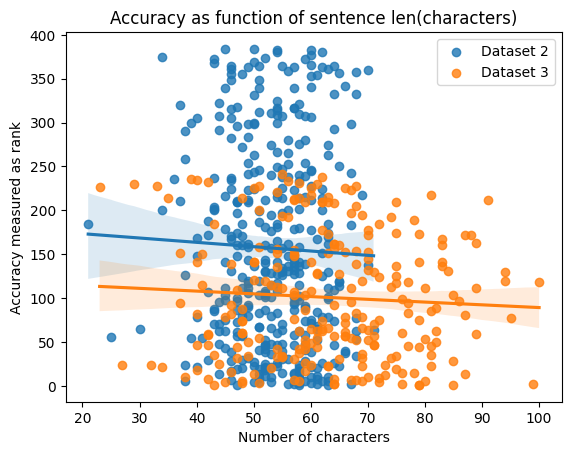

In [ ]:
x_list2 = list(len_dict2.values())
y_list2 = list(accuracy_dict2.values())

x_list3 = list(len_dict3.values())
y_list3 = list(accuracy_dict3.values())

sns.regplot(x=x_list2,y=y_list2,label="Dataset 2")
sns.regplot(x=x_list3,y=y_list3,label="Dataset 3")
plt.xlabel("Number of characters")
plt.ylabel("Accuracy measured as rank")
plt.title("Accuracy as function of sentence len(characters)")
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm

def analyze_linear_reg(x_lst, y_lst,num_dataset):
  x_with_constant = sm.add_constant(x_lst)
  model = sm.OLS(y_lst, x_with_constant)
  results = model.fit()
  # Get the coefficients and p-values
  intercept = results.params[0]
  slope = results.params[1]
  p_value = results.pvalues[1]
  #prints
  print(f"Results on Data set {num_dataset}:")
  print(f"Intercept: {intercept:.4f}")
  print(f"Slope: {slope:.4f}")
  print(f"P-value: {p_value:.4f}")


print('Data 2 Reggression results:')
analyze_linear_reg(x_list2,y_list2,2)
print()
print('Data 3 Reggression results:')
analyze_linear_reg(x_list3,y_list3,3)

Data 2 Reggression results:
Results on Data set 2:
Intercept: 183.2850
Slope: -0.4940
P-value: 0.5159

Data 3 Reggression results:
Results on Data set 3:
Intercept: 120.4668
Slope: -0.3129
P-value: 0.3243


**Exploring the length as number of characters using Spearman Test**

In [ ]:
from scipy import stats

print("Results on Dataset2:")
x_list2 = list(num_words_dict2.values())
res,pval = stats.spearmanr(x_list2,y_list2)
print(f'Coeff: {res}, Pval: {pval}')
print()

print("Results on Dataset3:")
x_list3 = list(num_words_dict3.values())
res,pval = stats.spearmanr(x_list3,y_list3)
print(f'Coeff: {res}, Pval: {pval}')

Results on Dataset2:
Coeff: -0.22525317394777142, Pval: 8.309060211750682e-06

Results on Dataset3:
Coeff: -0.1783265289416724, Pval: 0.005305374425744312


****Does the sentiment of a sentence have an affect on the success?****


In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

def calculate_sentiment(sentence):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(sentence)
    compound_score = sentiment_scores['compound']
    return compound_score

# dict of sentences and their sentiment ranging from -1 to 1
senti_dict2 = {string: calculate_sentiment(string) for string in sentences2}
senti_dict3 = {string: calculate_sentiment(string) for string in sentences3}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


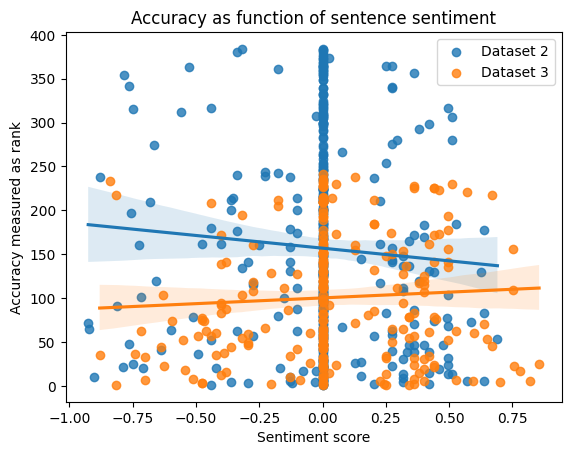

Data 2 Reggression results:
Results on Data set 2:
Intercept: 156.8823
Slope: -28.9395
P-value: 0.1790

Data 3 Reggression results:
Results on Data set 3:
Intercept: 100.1908
Slope: 13.1173
P-value: 0.3306


In [ ]:
x_list2 = list(senti_dict2.values())
x_list3 = list(senti_dict3.values())

sns.regplot(x=x_list2,y=y_list2,label="Dataset 2")
sns.regplot(x=x_list3,y=y_list3,label="Dataset 3")
plt.xlabel("Sentiment score")
plt.ylabel("Accuracy measured as rank")
plt.title("Accuracy as function of sentence sentiment")
plt.legend()
plt.show()

#######

print('Data 2 Reggression results:')
analyze_linear_reg(x_list2,y_list2,2)
print()
print('Data 3 Reggression results:')
analyze_linear_reg(x_list3,y_list3,3)

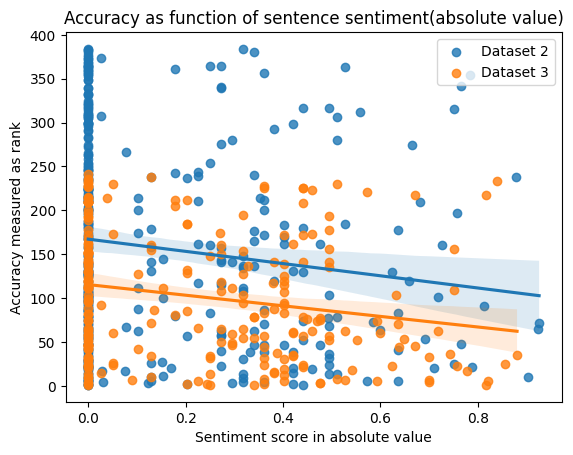

Data 2 Reggression results:
Results on Data set 2:
Intercept: 0.1469
Slope: -0.1668
P-value: 0.0001

Data 3 Reggression results:
Results on Data set 3:
Intercept: 0.2397
Slope: 0.0513
P-value: 0.2660


In [ ]:
abs_vals2 = [abs(x) for x in x_list2]
abs_vals3 = [abs(x) for x in x_list3]

sns.regplot(x=abs_vals2,y=y_list2,label="Dataset 2")
sns.regplot(x=abs_vals3,y=y_list3,label="Dataset 3")
plt.xlabel("Sentiment score in absolute value")
plt.ylabel("Accuracy measured as rank")
plt.title("Accuracy as function of sentence sentiment(absolute value)")
plt.legend()
plt.show()


#####################

print('Data 2 Reggression results:')
analyze_linear_reg(x_list2,abs_vals2,2)
print()
print('Data 3 Reggression results:')
analyze_linear_reg(x_list3,abs_vals3,3)

****Cluster investigation****

In [ ]:
# creating lists of the topics for each dataset

def compute_topic_lst(data_dict,sentences):
  sent_topic_lst = []
  for index,sentence in enumerate(sentences):
    current_passage_id = data_dict['labelsPassageForEachSentence'][index][0]
    current_topic_id = data_dict['labelsPassageCategory'][current_passage_id-1][0]
    current_topic = data_dict['keyPassageCategory'][0][current_topic_id-1][0]
    sent_topic_lst.append(current_topic)
  return sent_topic_lst

topiclst_2 = compute_topic_lst(exp2,sentences2)
topiclst_3 = compute_topic_lst(exp3,sentences3)

In [ ]:
#Checking topics distribution for both Datasets
#24 topics in each dataset

def compute_len_dist(topic_lst):
  original_len_lst = []
  for item in set(topiclst_3):
    count = 0
    for item2 in topiclst_3:
      if item2==item:
        count+=1
    original_len_lst.append(count)
  print(f'Number of items in a cluster range:({min(original_len_lst)},{max(original_len_lst)})')
  q1 = np.percentile(original_len_lst, 25)
  q3 = np.percentile(original_len_lst, 75)
  print("Q1:", q1)
  print("Q3:", q3)

print('Data set 2:')
compute_len_dist(topiclst_2)
print();
print('Data set 3:')
compute_len_dist(topiclst_3)

Data set 2:
Number of items in a cluster range:(9,11)
Q1: 10.0
Q3: 10.0

Data set 3:
Number of items in a cluster range:(9,11)
Q1: 10.0
Q3: 10.0


In [ ]:
from sklearn.cluster import KMeans

def runKmeans(num_clusters, vectors):
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(vectors)
  # Get the cluster labels for each vector
  cluster_labels = kmeans.labels_
  clusters_dict = {}
  for i in range(num_clusters):
    clusters_dict[i]= []
  # create a dict
  for i, label in enumerate(cluster_labels):
      clusters_dict[label].append(topiclst_2[i])
  return clusters_dict


In [ ]:
from collections import Counter

def calculate_most_frequent_value(dictionary):
    result = {}
    for key, values in dictionary.items():
        counter = Counter(values)
        most_common_value, count = counter.most_common(1)[0]
        result[key] = (most_common_value, count)
    return result


In [ ]:
def analyze_kmeans(k,vectors):
  clusters_dict = runKmeans(k,vectors)
  len_lst = []
  for value in clusters_dict.values():
    len_lst.append(len(value))
  print(f'Number of items in a cluster range:({min(len_lst)},{max(len_lst)})')
  q1 = np.percentile(len_lst, 25)
  q3 = np.percentile(len_lst, 75)
  print("Q1:", q1)
  print("Q3:", q3)
  # Calculate most frequent value and its count for each key
  result_dict = calculate_most_frequent_value(clusters_dict)
  percent_lst = []
  for key, (most_common_value, count) in result_dict.items():
      # print(f"For key '{key}', the most frequent value is {most_common_value} (appeared {count}/{len(clusters_dict[key])} times).")
      percent_lst.append(count/len(clusters_dict[key]))
  print(f'Average coverage of most common value {sum(percent_lst)/len(percent_lst)}')
  return clusters_dict

In [ ]:
print('Data set 2:')
original_cluster_dict2 = analyze_kmeans(24,exp2_vecs)
print()
print('Data set 3:')
original_cluster_dict3 = analyze_kmeans(24,exp3_vecs)

Data set 2:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of items in a cluster range:(4,37)
Q1: 12.0
Q3: 17.5
Average coverage of most common value 0.6299164771235505

Data set 3:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of items in a cluster range:(1,20)
Q1: 8.0
Q3: 13.25
Average coverage of most common value 0.41207869250632406


In [ ]:
original_cluster_dict2

{0: ['weapon',
  'weapon',
  'weapon',
  'weapon',
  'kitchen_utensil',
  'kitchen_utensil',
  'weapon',
  'weapon',
  'weapon',
  'weapon',
  'profession',
  'profession',
  'weapon',
  'weapon',
  'weapon'],
 1: ['building_part',
  'building_part',
  'building_part',
  'body_part',
  'building_part',
  'dwelling',
  'appliance',
  'building_part',
  'building_part',
  'building_part',
  'building_part',
  'building_part'],
 2: ['vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'tool',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'vehicles_transport',
  'place',
  'place',
  'place'],
 3: ['fish',
  'fish',
  'fish',
  'fish',
  'fish',
  'fish',
  'fish',
  'vehicles_transport',
  'animal',
  'animal',
  'animal'],
 4: ['dwelling',
  'vehicles_transport',
  'furniture',
  'furniture',
  'building_part',
  'kitchen_u

In [ ]:
original_cluster_dict3

{0: ['place'],
 1: ['insect',
  'profession',
  'profession',
  'profession',
  'animal',
  'animal',
  'animal',
  'animal',
  'furniture',
  'furniture',
  'dwelling',
  'insect'],
 2: ['profession',
  'profession',
  'appliance',
  'appliance',
  'appliance',
  'human',
  'human',
  'human',
  'building_part'],
 3: ['drink_non_alcoholic',
  'drink_non_alcoholic',
  'landscape',
  'landscape',
  'furniture',
  'furniture',
  'furniture',
  'clothing'],
 4: ['weapon',
  'appliance',
  'drink_non_alcoholic',
  'crime',
  'bird',
  'landscape',
  'landscape',
  'landscape',
  'weapon',
  'body_part',
  'crime',
  'crime',
  'bird'],
 5: ['fruit',
  'insect',
  'insect',
  'dwelling',
  'kitchen_utensil',
  'kitchen_utensil',
  'kitchen_utensil',
  'dwelling',
  'human',
  'human',
  'human',
  'drink_non_alcoholic',
  'drink_non_alcoholic',
  'drink_non_alcoholic',
  'crime'],
 6: ['weapon',
  'weapon',
  'fruit',
  'landscape',
  'building_part',
  'clothing',
  'crime',
  'crime',
  '

## We can do the same analysis using other representations.

Now looking at bert embeddings

**Dataset 2**

In [ ]:
print('Data set 2:')
BERT_cluster_dict2 = analyze_kmeans(24,embeddings)
print()
print('Data set 3:')
BERT_cluster_dict3 = analyze_kmeans(24,embeddings3)

Data set 2:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of items in a cluster range:(6,33)
Q1: 12.0
Q3: 19.0
Average coverage of most common value 0.5096581557656118

Data set 3:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of items in a cluster range:(4,16)
Q1: 8.75
Q3: 12.0
Average coverage of most common value 0.35730507918007914


In [ ]:
BERT_cluster_dict2

{0: ['insect',
  'insect',
  'insect',
  'animal',
  'animal',
  'animal',
  'animal',
  'animal',
  'animal',
  'body_part',
  'body_part',
  'insect',
  'insect',
  'fish',
  'fish',
  'insect',
  'insect',
  'insect',
  'insect'],
 1: ['furniture',
  'furniture',
  'furniture',
  'furniture',
  'animal',
  'body_part',
  'kitchen_utensil',
  'kitchen_utensil',
  'drink_non_alcoholic'],
 2: ['landscape',
  'place',
  'place',
  'place',
  'place',
  'landscape',
  'landscape',
  'vegetable',
  'fruit',
  'profession',
  'landscape',
  'landscape'],
 3: ['crime',
  'crime',
  'crime',
  'crime',
  'crime',
  'crime',
  'crime',
  'landscape',
  'weapon',
  'weapon',
  'crime',
  'crime',
  'crime',
  'crime',
  'crime',
  'crime',
  'crime',
  'crime'],
 4: ['appliance',
  'appliance',
  'furniture',
  'body_part',
  'kitchen_utensil',
  'kitchen_utensil',
  'dwelling',
  'kitchen_utensil',
  'kitchen_utensil',
  'appliance',
  'appliance',
  'tool',
  'tool',
  'tool',
  'tool',
  'w

In [ ]:
BERT_cluster_dict3

{0: ['bird',
  'disaster',
  'disaster',
  'disaster',
  'disaster',
  'animal',
  'animal',
  'animal',
  'body_part',
  'weapon'],
 1: ['music',
  'weapon',
  'human',
  'body_part',
  'place',
  'body_part',
  'body_part',
  'building_part',
  'building_part',
  'landscape',
  'human',
  'human',
  'crime'],
 2: ['vehicles_transport',
  'weapon',
  'landscape',
  'kitchen_utensil',
  'dwelling',
  'dwelling',
  'dwelling',
  'kitchen_utensil',
  'dwelling',
  'human',
  'human',
  'drink_non_alcoholic',
  'drink_non_alcoholic',
  'bird'],
 3: ['music',
  'dwelling',
  'fruit',
  'vegetable',
  'insect',
  'insect',
  'crime',
  'kitchen_utensil',
  'place',
  'dwelling',
  'vegetable',
  'insect'],
 4: ['insect',
  'profession',
  'furniture',
  'bird',
  'body_part',
  'body_part',
  'landscape',
  'kitchen_utensil',
  'kitchen_utensil',
  'vegetable',
  'body_part'],
 5: ['crime',
  'crime',
  'appliance',
  'bird',
  'body_part',
  'body_part',
  'dwelling',
  'place',
  'drink_n